# Autoencoder

## Data processing
### Libraries
First of all we load the libraries we need. We are gonna use the following Python modules:
- **numpy**: for numerical operations and arrays
- **matplotlib**: for plotting
- **tensorflow** and **keras**: for the neural network

All necessary libraries are installed in the virtual environment. If you want to install them in your own environment, you can do it from 'reqs.txt' with the following commands:

```bash
pip install -r reqs.txt
```

In [7]:
# load all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import  auc
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### Loading and preparing the data
Now we actually load the data, taking care to read the 'Data' column first as datetime and to then convert it to integer values, we read all other columns as float (we previously manually modified the data to be compatible with the default float format of pandas).

i.e.
we deleted the '.' from the thousands separator and replace the ',' with '.' for the decimal separator. Swapped ';' for ',' as the separator and deleted all spaces. This was achieved through the Vim editor by using the following commands:
```bash
:%s/,/./g
:%s/;/,/g
:%s/\.//g
:%s/ //g
:wq
```

In [8]:
# load the data from the file 'EWS.csv' and read column 'Data' as datetime and all others as floats
data = pd.read_csv('EWS.csv', parse_dates=['Data'], dayfirst=True)
# only take the first column of the data as Y
Y = data.iloc[:,0]
# take the rest of the columns as X
X = data.iloc[:,1:]
# convert the 'Data' column from datetime to int
X['Data'] = X['Data'].astype(np.int64)
# drop the 'Data' column from X
X = X.drop('Data', axis=1)
# print the head of the data
print(X.head())

   XAUBGNL  ECSURPUS    BDIY     CRY     DXY     JPY    GBP    Cl1    VIX   
0   283.25     0.077  1388.0  157.26  100.56  105.86  1.646  25.77  22.50  \
1   287.65     0.043  1405.0  165.01  101.86  105.47  1.638  28.85  21.50   
2   287.15     0.135  1368.0  167.24  102.41  106.04  1.650  28.28  23.02   
3   282.75     0.191  1311.0  166.85  104.92  107.85  1.611  28.22  23.45   
4   298.40     0.312  1277.0  165.43  104.22  109.30  1.611  28.02  21.25   

   USGG30YR  ...  LP01TREU  EMUSTRUU  LF94TRUU     MXUS    MXEU     MXJP   
0     6.671  ...   116.464   230.527   123.762  1416.12  127.75   990.59  \
1     6.747  ...   117.267   231.377   123.762  1428.79  129.50   993.98   
2     6.634  ...   117.995   232.390   123.762  1385.93  126.48   974.83   
3     6.423  ...   120.510   231.942   122.328  1385.31  129.19  1007.12   
4     6.231  ...   118.791   237.812   122.328  1411.95  134.67  1034.58   

     MXBR    MXRU    MXIN   MXCN  
0  856.76  224.33  217.34  34.30  
1  925.22 

### Data exploration
Now we do some basic data exploration to see what we are dealing with.

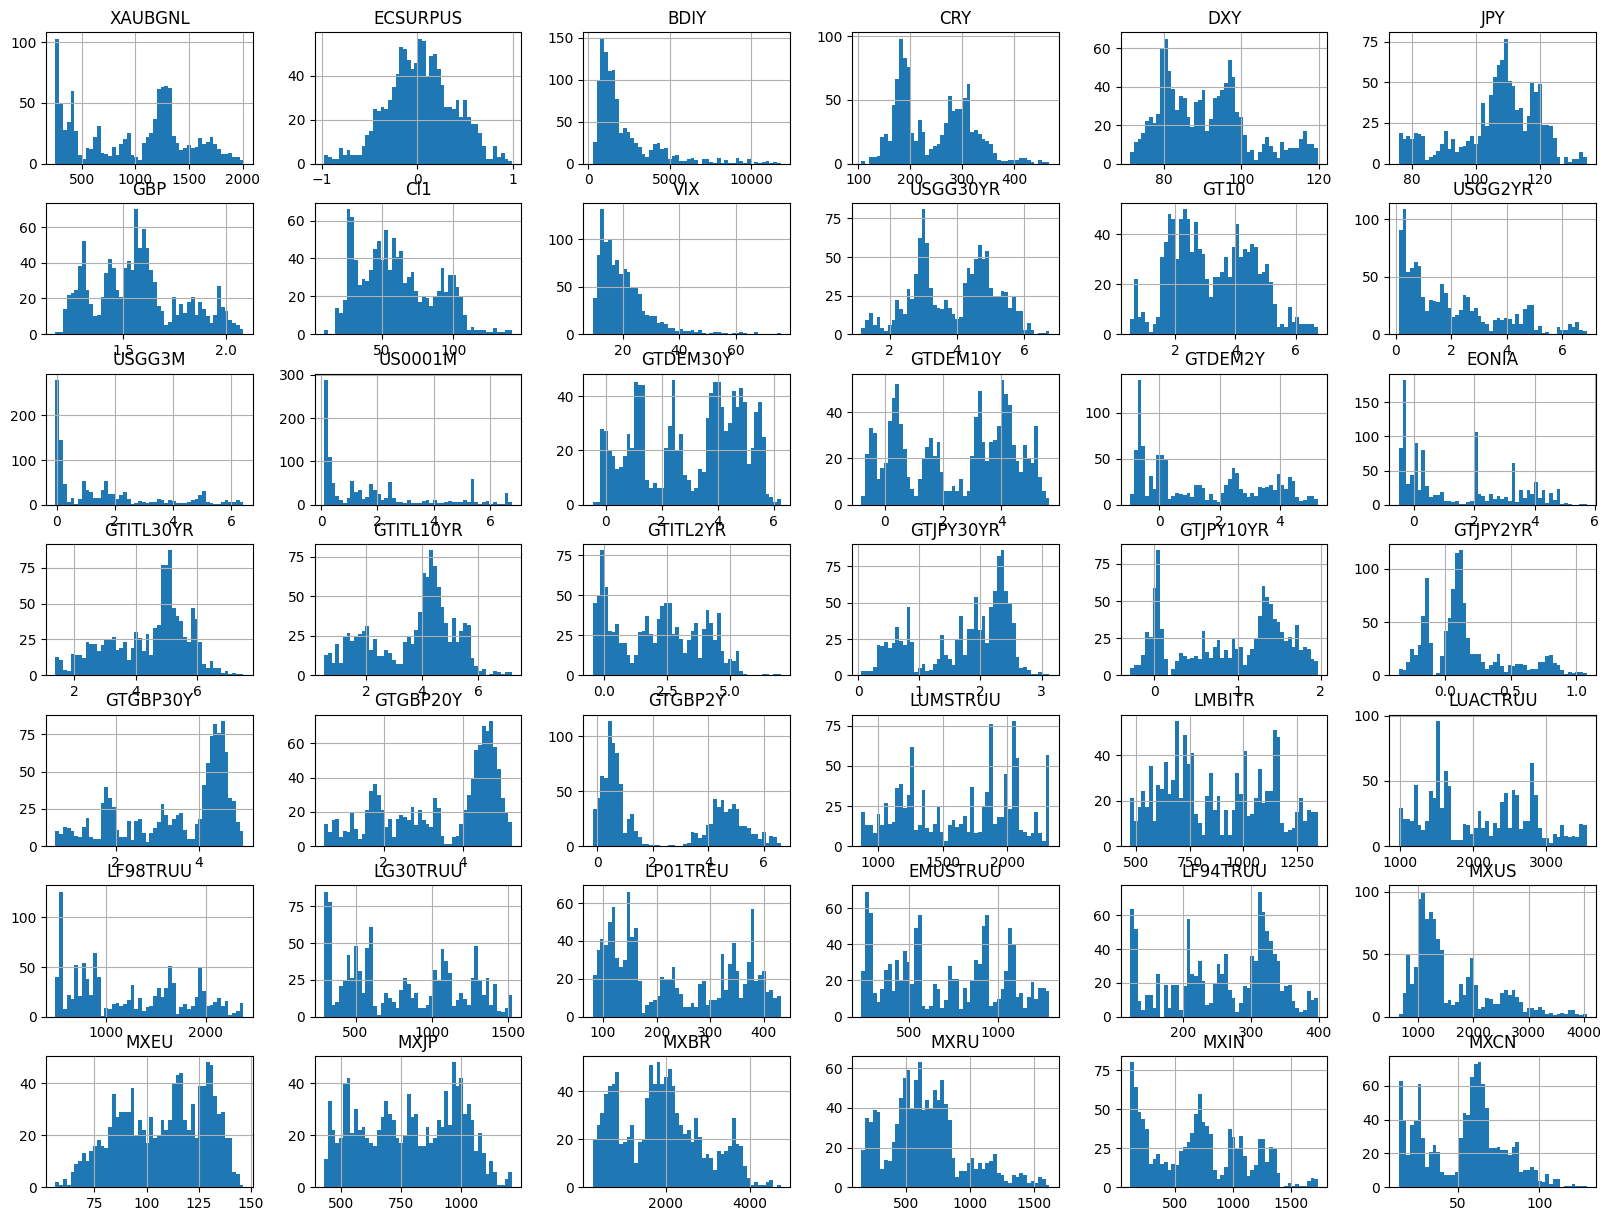

In [9]:
# create a histogram of the data for each column
X.hist(bins=50, figsize=(20,15))
plt.show()

### Data stabilization and normalization
We now try to stabilize our data, that is to say, we try to make the distribution of the data more uniform accross the time series.
We also differentiate between always positive data and possibly negative data.

In [10]:
# for always positive data we take logarithmic differences
Currencies = ['XAUBGNL', 'BDIY', 'CRY', 'Cl1', 'DXY', 'EMUSTRUU', 'GBP', 'JPY', 'LF94TRUU', 'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU', 'MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS', 'VIX']
X[Currencies] = np.log(X[Currencies]).diff()
# for possibly negative values we take just the differences
InterestRates = ['EONIA', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y', 'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR', 'US0001M', 'USGG3M', 'USGG2YR', 'GT10', 'USGG30YR']
X[InterestRates] = X[InterestRates].diff()
# we drop the rows with NaN values (first row of each column) from X and Y
nan_rows = X[X.isna().any(axis=1)].index
X = X.drop(nan_rows)
Y = Y.drop(nan_rows)
# reset the index of X and Y (otherwise we'd have problem with shuffling)
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

Now we try to normalize the data by zscore.

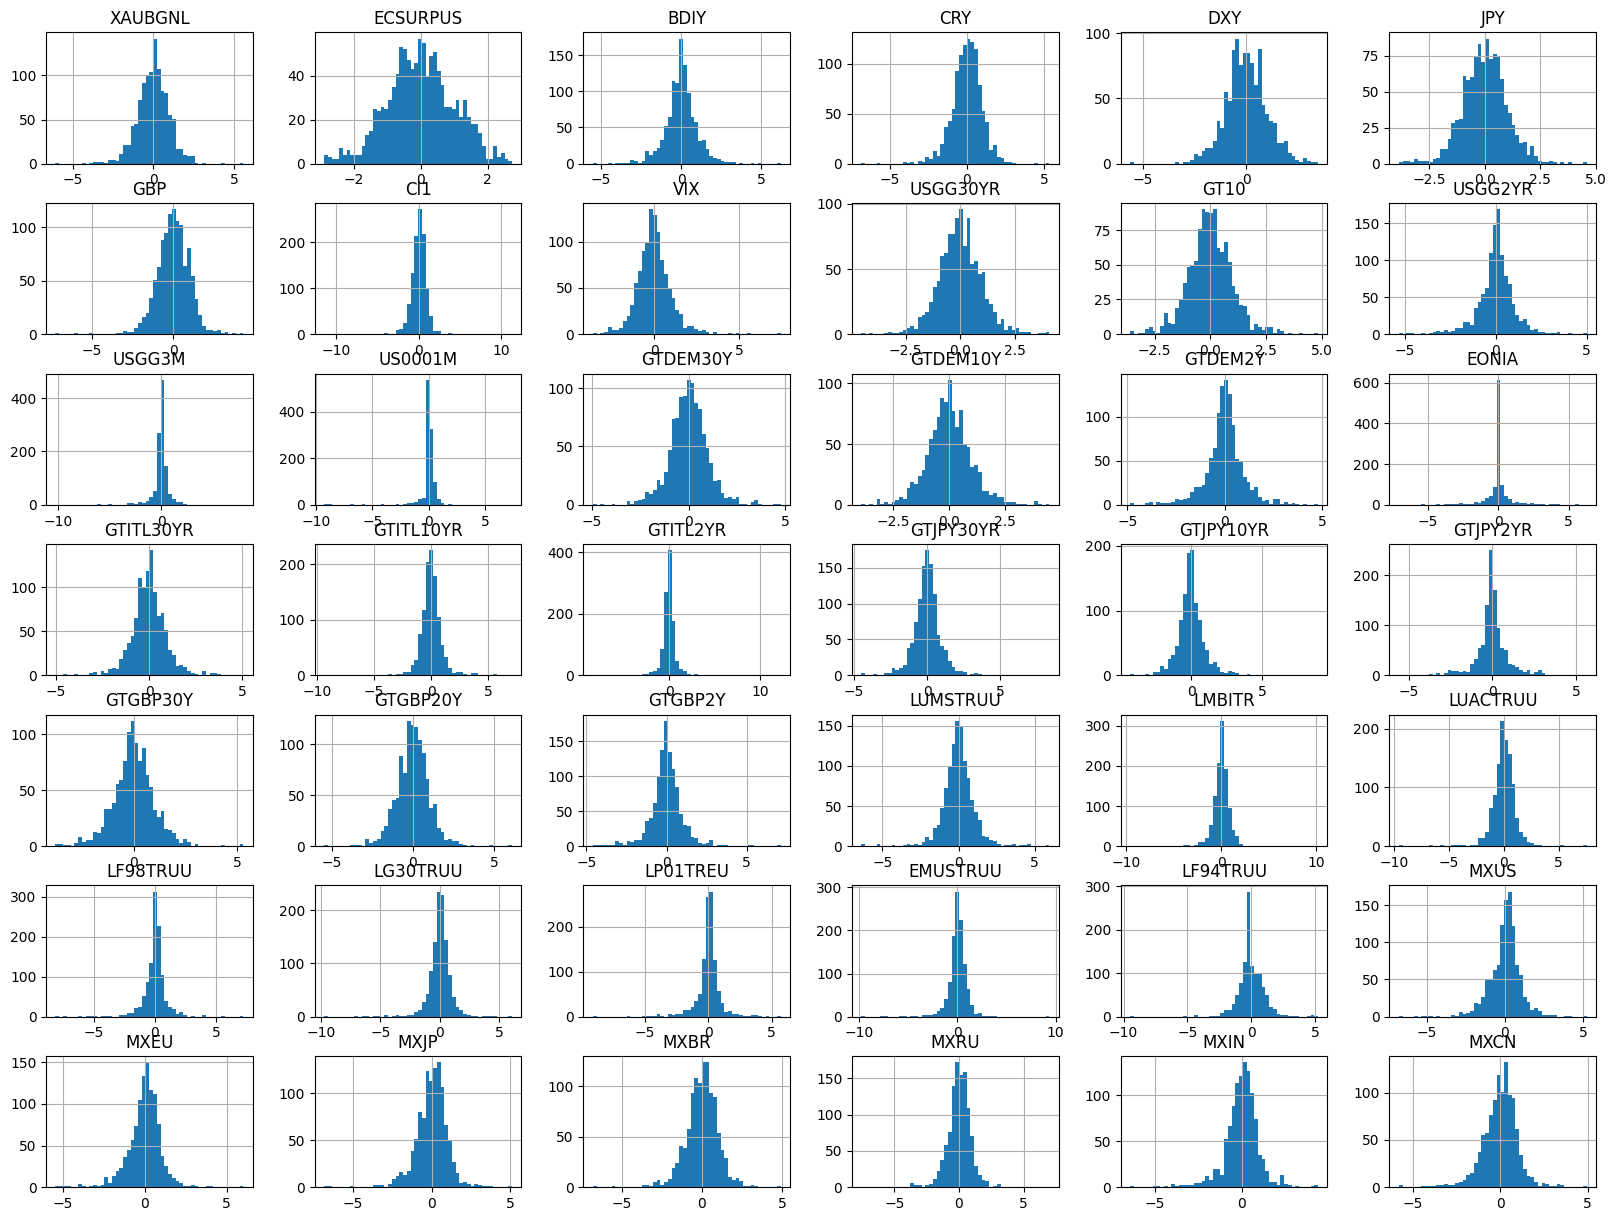

,XAUBGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,USGG30YR,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
count,1.110000e+03,1.110000e+03,1.110000e+03,1.110000e+03,1.110000e+03,1.110000e+03,1.110000e+03,1.110000e+03,1.110000e+03,1.110000e+03,...,1.110000e+03,1.110000e+03,1.110000e+03,1110.000000,1.110000e+03,1.110000e+03,1.110000e+03,1.110000e+03,1.110000e+03,1.110000e+03
mean,3.200643e-18,-3.840772e-17,-8.001607e-18,-1.600321e-17,-1.440289e-17,2.560514e-17,-4.000804e-19,-1.600321e-17,-2.440490e-17,1.360273e-17,...,1.600321e-18,3.200643e-18,-2.240450e-17,0.000000,-3.200643e-18,-3.200643e-18,1.280257e-17,-1.120225e-17,1.600321e-17,1.920386e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.061509e+00,-2.889170e+00,-5.521787e+00,-6.825692e+00,-5.632779e+00,-3.872610e+00,-7.213268e+00,-1.148524e+01,-3.596467e+00,-4.514278e+00,...,-9.126055e+00,-9.764306e+00,-9.487869e+00,-6.764999,-5.434631e+00,-6.847483e+00,-6.797175e+00,-7.545314e+00,-6.441112e+00,-5.783319e+00
25%,-5.757297e-01,-6.496337e-01,-4.881292e-01,-5.328172e-01,-6.188955e-01,-6.411932e-01,-5.743697e-01,-4.766220e-01,-5.916200e-01,-5.978216e-01,...,-2.598345e-01,-3.402815e-01,-4.720042e-01,-0.471654,-4.422944e-01,-5.182708e-01,-5.655085e-01,-4.669082e-01,-4.559912e-01,-5.197374e-01
50%,3.566870e-02,-3.228675e-03,5.839142e-03,6.058842e-02,-5.139470e-02,2.050425e-02,1.107775e-02,4.860152e-02,-3.988953e-02,-1.862731e-02,...,6.223306e-02,4.881509e-02,-9.963877e-02,0.101603,9.503269e-02,6.803124e-02,5.446646e-02,4.049738e-02,7.205045e-02,7.549034e-02
75%,5.897124e-01,6.424613e-01,5.129704e-01,5.992620e-01,6.332781e-01,6.200170e-01,6.138606e-01,5.264337e-01,5.177757e-01,6.042363e-01,...,3.605015e-01,4.461213e-01,5.155251e-01,0.522006,5.623173e-01,6.103153e-01,6.158633e-01,5.662642e-01,5.418269e-01,5.971832e-01
max,5.582727e+00,2.731122e+00,6.229681e+00,5.335575e+00,3.490680e+00,4.592178e+00,4.295274e+00,1.130508e+01,7.424652e+00,4.081700e+00,...,5.714895e+00,9.353797e+00,5.241234e+00,5.207630,6.025704e+00,5.115067e+00,4.908420e+00,6.993618e+00,4.410298e+00,4.937399e+00


In [11]:
# normalize the data by zscoring maybe min-max is better
X = (X - X.mean()) / X.std()
# replot the histograms
X.hist(bins=50, figsize=(20,15))
plt.show()
# check that it has mean zero and std one
X.describe()

### Data partitioning
Split the data between training & validation and test set.
We choose the following partitioning:
- Training set: 80% (only normal data, Y=0)
- Cross-validation set: 10% (50% Y=0, 50% Y=1)
- Test set: 10% (50% Y=0, 50% Y=1)

In [12]:
# first we shuffle the data around (both X and Y)
# create a random permutation of the indices of X (seed is set for reproducibility)
permutation = np.random.RandomState(seed=42).permutation(X.index)
# shuffle X and Y according to the permutation
X = X.reindex(permutation)
Y = Y.reindex(permutation)

# get the normal data (Y = 0)
Y_normal = Y[Y==0]
X_normal = X[Y == 0]
# get the abnormal data (Y = 1)
Y_abnormal = Y[Y==1]
X_abnormal = X[Y == 1]

# create the training set as 80% of all normaldata
X_train = X_normal[:int(0.8*len(X_normal))]
Y_train = Y_normal[:int(0.8*len(Y_normal))]
# create the cross-validation set as 10% of all normaldata and 50% of all abnormal data
X_cv = pd.concat([
    X_normal[int(0.8*len(X_normal)):int(0.9*len(X_normal))],
    X_abnormal[:int(0.5*len(X_abnormal))]
])
Y_cv = pd.concat([
    Y_normal[int(0.8*len(Y_normal)):int(0.9*len(Y_normal))],
    Y_abnormal[:int(0.5*len(Y_abnormal))]
])
# create the test set as 10% of all normaldata and 50% of all abnormal data
X_test = pd.concat([
    X_normal[int(0.9*len(X_normal)):],
    X_abnormal[int(0.5*len(X_abnormal)):]
])
Y_test = pd.concat([
    Y_normal[int(0.9*len(Y_normal)):],
    Y_abnormal[int(0.5*len(Y_abnormal)):]
])

## Neural network
### Model definition
We now pass to define the model.

We the layers as follows:

1. Encoder:

- Input layer: 1 neuron for each feature (i.e. 1 neuron for each column of the data, we exclude the 'Data' column)

- First Hidden layer: 20 neurons with relu activation function

- Second Hidden layer: 10 neurons with relu activation function

- Output layer (Encoded layer): 5 neurons with relu activation function

2. Decoder:

- Third Hidden layer: 10 neurons with relu activation function

- Fourth Hidden layer: 20 neurons with relu activation function

- Output layer (Decoded layer): 1 neuron for each feature (i.e. 1 neuron for each column of the data)

**N.B.**
given this stackoverflow [answer](https://stackoverflow.com/questions/49823192/autoencoder-gridsearch-hyperparameter-tuning-keras) we should have a fairly complex network since we have 42 features. We will see if this is true.
This model has 2,287 trainable parameters.

In [13]:
# Define the autoencoder model
input_dim = X_train.shape[1]
# define the layer size
first_hidden_dim = 20
second_hidden_dim = 10
encoding_dim = 5

#create the various layers of the model
# input layer with input_dim neurons
input_layer = Input(shape=(input_dim,))
# first hidden layer with first_hidden_dim neurons and relu activation function
hidden_layer_1 = Dense(first_hidden_dim, activation='relu')(input_layer)
#secon hidden layer with second_hidden_dim neurons and relu activation function
hidden_layer_2 = Dense(second_hidden_dim, activation='relu')(hidden_layer_1)
# encoded layer with encoding_dim neurons and relu activation function
encoded_layer = Dense(encoding_dim, activation='relu')(hidden_layer_2)
# third hidden layer with second_hidden_dim neurons and relu activation function
hidden_layer_3 = Dense(second_hidden_dim, activation='relu')(encoded_layer)
# fourth hidden layer with first_hidden_dim neurons and relu activation function
hidden_layer_4 = Dense(first_hidden_dim, activation='relu')(hidden_layer_3)
# output layer with input_dim neurons
output_layer = Dense(input_dim)(hidden_layer_4)

model = Model(input_layer, output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42)]              0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 10)                60        
                                                                 
 dense_4 (Dense)             (None, 20)                220       
                                                                 
 dense_5 (Dense)             (None, 42)                882   

### Model training and best hyperparameters search
Now we compile and train the model.
We do a cross-validation to find the best hyperparameters.

**N.B.** Do not run this cell unless you specifically want to retrain the model. It takes a long time (about 5 minutes on my machine).
Run the next cell to load the data from the saved learning rates.

In [ ]:
# create a vector of 100 between 10^-6 and 10^-1
N_lr = 100
learning_rates = np.logspace(-6, -1, N_lr)
# create a vector to store the best epoch for each learning rate
best_epochs = np.zeros(len(learning_rates))
# create a vector to store the best validation loss for each learning rate
best_val_loss = np.zeros(len(learning_rates))

# fix the number of epochs and the batch size (maybe we could tinker with them to obtain better results)
epochs = 100
batch_size = 32

# for each learning rate
for learning_rate in learning_rates:
    # get the index of the current learning rate
    i = np.where(learning_rates == learning_rate)[0][0]
    # get the percentage and "ventage" of the current learning rate
    perc = int((i+1)/N_lr * 100)
    vent = int(perc/5)
    # print the current learning rate, a progress bar, the percentage and the number of total learning rates in parenthesis
    print(f""" -> learning rate {learning_rate}
    [{''.join(['='] * vent)}{'>' if vent != 20 else ''}{''.join(['-'] * (19-vent))}] {perc}% ({N_lr})
    """)
    # Compile and train the model with the current learning rate
    # use the mean squared error as loss function
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    # set the early stopping callback to stop the training if the validation loss does not decrease for 10 epochs and restore the best weights
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    # train and validate the model on the training set and the cross-validation set
    history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_cv, X_cv), verbose=1, callbacks=[early_stopping])
    # add its best epoch to the vector of best epochs
    best_epoch = np.argmin(history.history['val_loss'])
    best_epochs[np.where(learning_rates == learning_rate)[0][0]] = best_epoch
    # add its loss value to the vector of losses
    best_val_loss[np.where(learning_rates == learning_rate)[0][0]] = history.history['val_loss'][best_epoch]
    # clear the printed output with the progress of the training to declutter
    clear_output(wait=True)

# save the best epochs and the best validation losses to a csv file via pandas
pd.DataFrame({
    'learning_rate': learning_rates,
    'best_epoch': best_epochs,
    'best_val_loss': best_val_loss
}).to_csv('losses.csv', index=False)

### Best Learning Rate
Now we find the best learning rate based on the cross-validation loss. For each learning rate we take into consideration the best loss value across all epochs.

The data is loaded from the saved learning rates file (see previous cell, 'losses.csv').

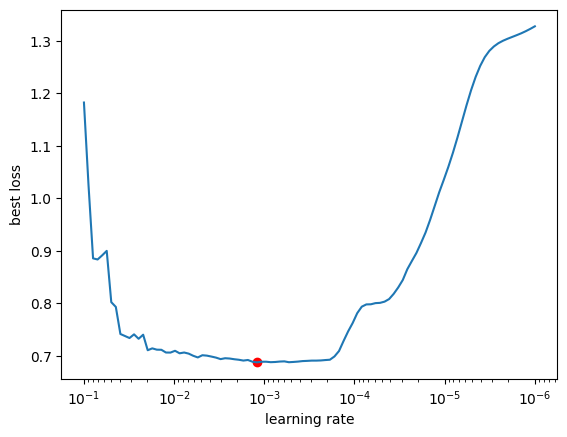

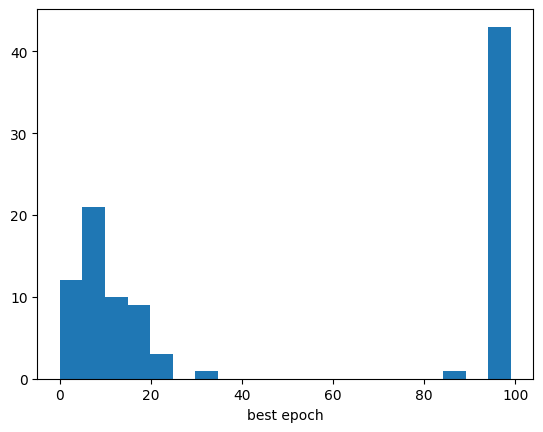

In [3]:
# load the learning rates, losses and best epochs from the csv file
losses_df = pd.read_csv('losses.csv')
learning_rates = losses_df['learning_rate']
best_epochs = losses_df['best_epoch']
losses = losses_df['best_val_loss']
# plot the losses for each learning rate
plt.plot(learning_rates, losses)
plt.xlabel('learning rate')
# plot the best learning rate
plt.scatter(learning_rates[np.argmin(losses)], np.min(losses), color='red')
# invert the x axis to reflect the order we used and set the x axis to logarithmic scale
plt.gca().invert_xaxis()
plt.xscale('log')
# set the x axis to logarithmic scale
plt.ylabel('best loss')
plt.show()
# plot a histogram of the best epochs
plt.hist(best_epochs, bins=20)
plt.xlabel('best epoch')
plt.show()

In [4]:
# Find the best learning rate
# find the index of the minimum value in the losses vector
best_learning_rate_index = np.argmin(losses)
# find the best learning rate
best_learning_rate = learning_rates[best_learning_rate_index]
# print the best learning rate
print(f"""Best learning rate:
--> {best_learning_rate}""")

Best learning rate:
--> 0.0012045035402587


### Compile and train the model for the best learning rate
Now we compile and train the model for the best learning rate and plot its loss curve.

In [14]:
# Compile and train the model for the best learning rate
model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
history = model.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_cv, X_cv), verbose=1, callbacks=[early_stopping])
# get the best epoch and the best loss
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
# print the best epoch and the best loss
print('Best epoch: {}'.format(best_epoch))
print('Best loss: {}'.format(best_loss))

Epoch 1/100
22/22 [==============================] - 1s 9ms/step - loss: 0.7384 - val_loss: 1.2834
Epoch 2/100
22/22 [==============================] - 0s 2ms/step - loss: 0.7152 - val_loss: 1.2207
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 0.6815 - val_loss: 1.1702
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6553 - val_loss: 1.1525
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: 0.6406 - val_loss: 1.1478
Epoch 6/100
22/22 [==============================] - 0s 2ms/step - loss: 0.6284 - val_loss: 1.1442
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 0.6172 - val_loss: 1.1344
Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: 0.6035 - val_loss: 1.1223
Epoch 9/100
22/22 [==============================] - 0s 2ms/step - loss: 0.5866 - val_loss: 1.1071
Epoch 10/100
22/22 [==============================] - 0s 2ms/step - loss: 0.5707 - val_loss: 1.0991
Epoch 11/

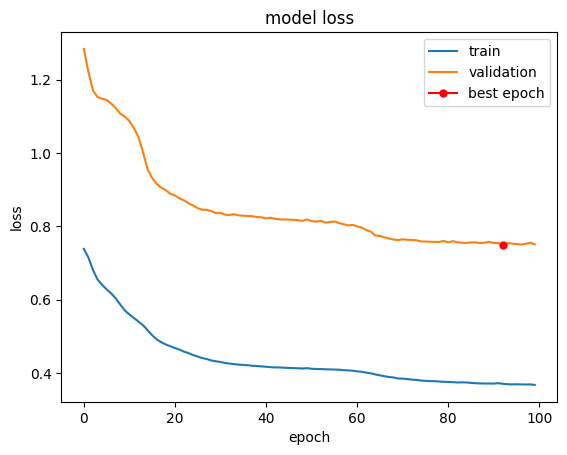

In [15]:
# plot the training and validation loss for the best learning rate
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# highlight the best epoch and the best loss
plt.plot(best_epoch, best_loss, marker='o', markersize=5, color="red")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'best epoch'], loc='upper right')
plt.show()

### Model evaluation and best threshold search
We now evaluate the model on the validation set and find the best threshold for anomaly detection.

In [16]:
# Make a predicition on the validation set
prediction_cv = model.predict(X_cv)
# get the mean squared errors for the predictions on the validation set
mse_cv = np.mean(np.power(X_cv - prediction_cv, 2), axis=1)

7/7 [==============================] - 0s 1ms/step


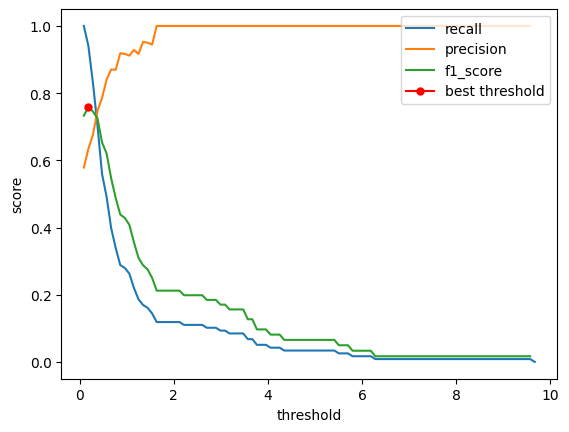

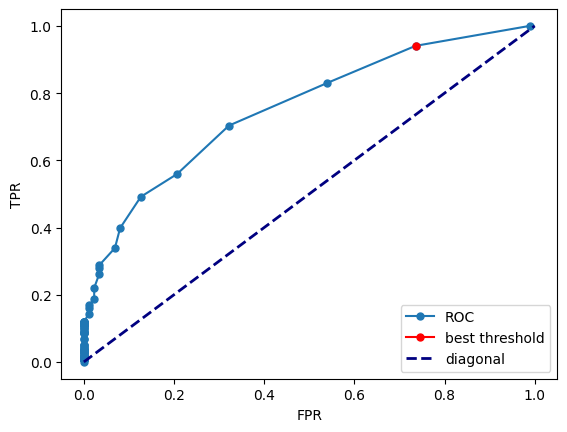

AUC score: 0.743


In [26]:
# find the best threshold for the reconstruction error (on the validation set)

# create a vector of 100 values between the minimum and maximum reconstruction error
thresholds = np.linspace(np.min(mse_cv), np.max(mse_cv), 100)
# create a dataframe with first column the thresholds above, then a column for true positives, false positives, true negatives and false negatives, then a column for recall, precision and f1 score
df = pd.DataFrame(thresholds, columns=['threshold'])
df['tp'] = np.zeros(len(thresholds))
df['fp'] = np.zeros(len(thresholds))
df['tn'] = np.zeros(len(thresholds))
df['fn'] = np.zeros(len(thresholds))
df['recall'] = np.zeros(len(thresholds))
df['precision'] = np.zeros(len(thresholds))
df['f1_score'] = np.zeros(len(thresholds))

# for each threshold
for threshold in thresholds:
    # create the confusion matrix
    tp = np.sum(np.logical_and(mse_cv > threshold,  Y_cv== 1))
    fp = np.sum(np.logical_and(mse_cv > threshold,  Y_cv== 0))
    tn = np.sum(np.logical_and(mse_cv <= threshold, Y_cv == 0))
    fn = np.sum(np.logical_and(mse_cv <= threshold, Y_cv == 1))
    # store the confusion matrix in the dataframe
    df.loc[df['threshold'] == threshold, 'tp'] = tp
    df.loc[df['threshold'] == threshold, 'fp'] = fp
    df.loc[df['threshold'] == threshold, 'tn'] = tn
    df.loc[df['threshold'] == threshold, 'fn'] = fn

# calculate the recall, precision and f1 score for each threshold
df['recall'] = df['tp']/(df['tp']+df['fn'])
df['precision'] = df['tp']/(df['tp']+df['fp'])
df['f1_score'] = 2*df['precision']*df['recall']/(df['precision']+df['recall'])

# plot the recall, precision and f1 score for each threshold
plt.plot(df['threshold'], df['recall'])
plt.plot(df['threshold'], df['precision'])
plt.plot(df['threshold'], df['f1_score'])
# plot the best threshold and the best f1 score
plt.plot(df.loc[df['f1_score'].idxmax(), 'threshold'], df.loc[df['f1_score'].idxmax(), 'f1_score'], marker='o', markersize=5, color="red")
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend(['recall', 'precision', 'f1_score', 'best threshold'], loc='upper right')
plt.show()

# calculate the TPR and FPR for each threshold
df['TPR'] = df['tp']/(df['tp']+df['fn'])
df['FPR'] = df['fp']/(df['fp']+df['tn'])
# compute the AUC score
auc_score = auc(df['FPR'], df['TPR'])
# plot the ROC curve with the points for each threshold
plt.plot(df['FPR'], df['TPR'], marker='o', markersize=5)
# plot the FPR and TPR for the best threshold
plt.plot(df.loc[df['f1_score'].idxmax(), 'FPR'], df.loc[df['f1_score'].idxmax(), 'TPR'], marker='o', markersize=5, color="red")
# plot the diagonal
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(['ROC', 'best threshold', 'diagonal'], loc='lower right')
# add the AUC score to the plot
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
# print the AUC score
print(f'AUC score: {auc_score:.3f}')

#### Best threshold and F1 score

In [27]:
# computing

# find the best threshold based on the f1 score
best_threshold = df.loc[df['f1_score'].idxmax()]['threshold']
# extract the true positives, false positives, true negatives and false negatives for the best threshold
tp = df.loc[df['threshold'] == best_threshold, 'tp'].values[0]
fp = df.loc[df['threshold'] == best_threshold, 'fp'].values[0]
tn = df.loc[df['threshold'] == best_threshold, 'tn'].values[0]
fn = df.loc[df['threshold'] == best_threshold, 'fn'].values[0]
# extract the recall, precision and f1 score for the best threshold
recall = df.loc[df['threshold'] == best_threshold, 'recall'].values[0]
precision = df.loc[df['threshold'] == best_threshold, 'precision'].values[0]
f1_score = df.loc[df['threshold'] == best_threshold, 'f1_score'].values[0]

# transform the tp, fp, tn and fn into strings and add spaces to align the confusion matrix
tp = str(int(tp)) + ' '*(4-len(str(int(tp))))
fp = str(int(fp)) + ' '*(4-len(str(int(fp))))
tn = str(int(tn)) + ' '*(4-len(str(int(tn))))
fn = str(int(fn)) + ' '*(4-len(str(int(fn))))

# print the results (best threshold, confusion matrix and metrics)
print(
f""">-- Results (Cross-validation set) --<
Best threshold: {round(best_threshold,4)}

--- Confusion Matrix ---
       Predicted
       Normal  Anomaly
Actual
Normal   {tn}      {fp}
Anomaly  {fn}      {tp}

--- Metrics ---
Recall: {round(precision,2)}
Precision: {round(recall,2)}
F1 score: {round(f1_score,2)}
""")

>-- Results (Cross-validation set) --<
Best threshold: 0.1846

--- Confusion Matrix ---
       Predicted
       Normal  Anomaly
Actual
Normal   23        64  
Anomaly  7         111 

--- Metrics ---
Recall: 0.63
Precision: 0.94
F1 score: 0.76



### Model evaluation on the test set

In [28]:
# Make a prediction on the test set
prediction_test = model.predict(X_test)
# get the mean squared errors for the predictions on the test set
mse_test = np.mean(np.power(X_test - prediction_test, 2), axis=1)
# use the best threshold to make predictions on the test set
predictions = np.where(mse_test > best_threshold, 1, 0)
# compute the number of actual anomalies and normal points in the test set
actual_anomalies = np.sum(Y_test == 1)
actual_normals = np.sum(Y_test == 0)
# compute predicted anomalies and normal points in the test set
predicted_anomalies = np.sum(predictions == 1)
predicted_normals = np.sum(predictions == 0)

# compute the number of true positives, false positives, true negatives and false negatives for the best threshold
tp = np.sum(np.logical_and(predictions == 1, Y_test == 1))
fp = np.sum(np.logical_and(predictions == 1, Y_test == 0))
tn = np.sum(np.logical_and(predictions == 0, Y_test == 0))
fn = np.sum(np.logical_and(predictions == 0, Y_test == 1))
# compute the recall, precision and f1 score
recall = tp/(tp+fn)
precision = tp/(tp+fp)
f1_score = 2*tp/(2*tp+fp+fn)

# transform the tp, fp, tn and fn into strings and add spaces to align the confusion matrix
tp = str(int(tp)) + ' '*(4-len(str(int(tp))))
fp = str(int(fp)) + ' '*(4-len(str(int(fp))))
tn = str(int(tn)) + ' '*(4-len(str(int(tn))))
fn = str(int(fn)) + ' '*(4-len(str(int(fn))))

# print the confusion matrix and metrics
print(
f"""
>--Results (Test set) --<

--- Confusion Matrix ---
       Predicted
       Normal  Anomaly Total
Actual
Normal   {tn}      {fp} ({actual_normals})
Anomaly  {fn}      {tp} ({actual_anomalies})
Total   ({predicted_normals})     ({predicted_anomalies})

--- Metrics ---
Recall: {round(recall,2)}
Precision: {round(precision,2)}
F1 Score: {round(f1_score,2)}
"""
)

7/7 [==============================] - 0s 938us/step

>--Results (Test set) --<

--- Confusion Matrix ---
       Predicted
       Normal  Anomaly Total
Actual
Normal   21        67   (88)
Anomaly  3         116  (119)
Total   (24)     (183)

--- Metrics ---
Recall: 0.97
Precision: 0.63
F1 Score: 0.77

